In [1]:
!pip install -q roboflow 

     |████████████████████████████████| 145 kB 7.4 MB/s 
     |████████████████████████████████| 178 kB 59.0 MB/s 
     |████████████████████████████████| 3.1 MB 58.9 MB/s 
     |████████████████████████████████| 1.1 MB 74.7 MB/s 
     |████████████████████████████████| 21.8 MB 1.5 MB/s 
     |████████████████████████████████| 67 kB 8.4 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 138 kB 56.0 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you h

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import cv2
import pathlib
from google.colab.patches import cv2_imshow
import random
import pandas as pd

In [4]:
data_dir = "/content/gdrive/MyDrive/Image Classification/Background"
data_path = pathlib.Path(data_dir)
backgrounds = list(data_path.glob("*.jpg"))

In [5]:
def yolo_to_opencv(img, img2_label):
  img2 = img
  dh, dw, _ = img2.shape
  x, y, w, h = map(float, img2_label)
  #img = img2
  l = int((x - w / 2) * dw)
  r = int((x + w / 2) * dw)
  t = int((y - h / 2) * dh)
  b = int((y + h / 2) * dh)

  if l < 0:
      l = 0
  if r > dw - 1:
      r = dw - 1
  if t < 0:
      t = 0
  if b > dh - 1:
      b = dh - 1

  #cv2.rectangle(img2, (l, t), (r, b), (0, 0, 255), 2)     return [(l, t), (r, b)]
  return [l, t, r, b]

In [6]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [16]:
#creating augmented labels in 'yolo' format with random placements.
def create_augments(fg1, bg_list, labels = None, n = 3):
  labels_fin = None
  aug_list = []
  class_label = [labels.pop(0)]
  print(labels)
  for bg in bg_list:
    back11 = cv2.imread(str(bg))
    back11 = cv2.resize(back11, (416,416), interpolation = cv2.INTER_CUBIC)
    back1 = back11
    flake = fg1
    #cv2_imshow(back1)
    for i in range(n):
      #print(i)
      back1 = back11
      #cv2_imshow(back11)
      flake = fg1
      x_offset = random.randint(0, back1.shape[0] - flake.shape[0])
      y_offset = random.randint(0, back1.shape[1] - flake.shape[1])
      x_end = x_offset + flake.shape[1]
      y_end = y_offset + flake.shape[0]

      if labels is not None:

        cv_labels = yolo_to_opencv(img = fg1, img2_label = labels)
        xmin = cv_labels[0] + x_offset
        ymin = cv_labels[0] + y_offset
        xmax = cv_labels[0] + x_offset
        ymax = cv_labels[0] + y_offset
        bbox = [xmin, ymin, xmax, ymax]
        w = bg.shape[1]
        h = bg.shape[0]
        labels_fin = class_label + xml_to_yolo_bbox(bbox, w, h)


      small_img_gray = cv2.cvtColor(flake, cv2.COLOR_RGB2GRAY)
      #cv2_imshow(small_img_gray)

      ret, mask = cv2.threshold(small_img_gray, 170, 255, cv2.THRESH_BINARY)
      #cv2_imshow(mask)

      rows,columns,chanels = flake.shape
      roi = back1[y_offset:y_offset+columns, x_offset:x_offset+rows]

      bg = cv2.bitwise_or(roi,roi,mask = mask)

      mask_inv = cv2.bitwise_not(small_img_gray)
      #cv2_imshow(mask_inv)

      fg = cv2.bitwise_and(flake,flake, mask=mask_inv)
      #cv2_imshow(fg)

      final_roi = cv2.add(bg,fg)
      #cv2_imshow(final_roi)

      small_img = final_roi

      back1[y_offset : y_offset + small_img.shape[0], x_offset : x_offset + small_img.shape[1]]= small_img

      aug_list.append(back1)
      #cv2_imshow(back11)
  return aug_list

In [17]:
#creating augmented labels in 'yolo' format with ordered matrix style placements.
def create_augments_v2(fg1, bg_list, labels = None, i = 3, j = 3):
  class_label = [labels.pop(0)]
  print(labels)
  labels_fin = None
  aug_list = []
  for bg in bg_list:
    back11 = cv2.imread(str(bg))
    back11 = cv2.resize(back11, (416,416), interpolation = cv2.INTER_CUBIC)
    back1 = back11
    flake = fg1
    #cv2_imshow(back1)
    
    #print(i)
    back1 = back11
    #cv2_imshow(back11)
    flake = fg1
    x_offset = i * fg1.shape[0]
    y_offset = j * fg1.shape[1]
    x_end = x_offset + flake.shape[1]
    y_end = y_offset + flake.shape[0]

    if labels is not None:
        
        cv_labels = yolo_to_opencv(img = fg1, img2_label = labels)
        xmin = cv_labels[0] + x_offset
        ymin = cv_labels[1] + y_offset
        xmax = cv_labels[2] + x_offset
        ymax = cv_labels[3] + y_offset
        bbox = [xmin, ymin, xmax, ymax]
        w = back11.shape[1]
        h = back11.shape[0]
        labels_fin = class_label + xml_to_yolo_bbox(bbox, w, h)
        # print(bbox)
        # print(labels_fin)

    small_img_gray = cv2.cvtColor(flake, cv2.COLOR_RGB2GRAY)
    #cv2_imshow(small_img_gray)                 #uncomment this to check for threshold

    ret, mask = cv2.threshold(small_img_gray, 240, 255, cv2.THRESH_BINARY) #change the lower threshold 240
    #cv2_imshow(mask)                           #uncomment this to check for threshold

    rows,columns,chanels = flake.shape
    roi = back1[y_offset:y_offset+columns, x_offset:x_offset+rows]

    bg = cv2.bitwise_or(roi,roi,mask = mask)
    #cv2_imshow(bg)                           

    mask_inv = cv2.bitwise_not(mask)
    #cv2_imshow(mask_inv)

    fg = cv2.bitwise_and(flake,flake, mask=mask_inv)
    #cv2_imshow(fg)

    final_roi = cv2.add(bg,fg)
    #cv2_imshow(final_roi)

    small_img = final_roi

    back1[y_offset : y_offset + small_img.shape[0], x_offset : x_offset + small_img.shape[1]]= small_img

    aug_list.append((back1, labels_fin))
    #cv2_imshow(back11)
  #return aug_list
  return aug_list

In [9]:
img_orig = cv2.imread('/content/gdrive/MyDrive/Image Classification/Dataset_for_demo/25--1/train/images/2-28842_eggs-vector-chocolate-egg-easter-egg-vector-file_png_jpg.rf.ad0da2be52452b7ce66a6eff7f601f68.jpg')
img2_label = pd.read_csv("/content/gdrive/MyDrive/Image Classification/Dataset_for_demo/25--1/train/labels/2-28842_eggs-vector-chocolate-egg-easter-egg-vector-file_png_jpg.rf.ad0da2be52452b7ce66a6eff7f601f68.txt", sep = ' ')

['0.49278846153846156', '0.484375', '0.7115384615384616', '0.9399038461538461']


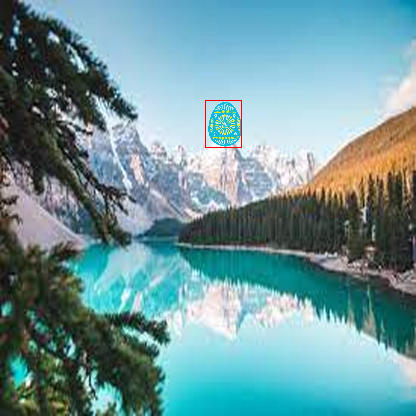

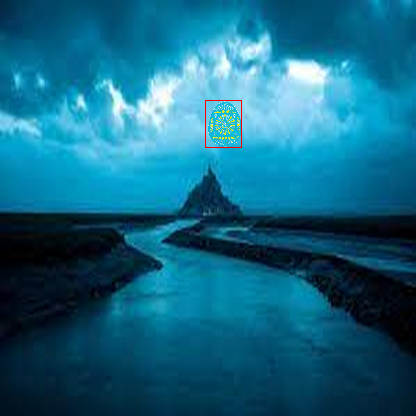

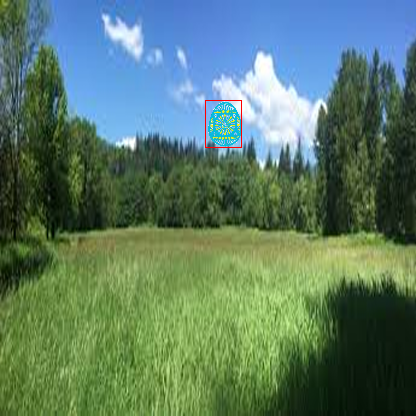

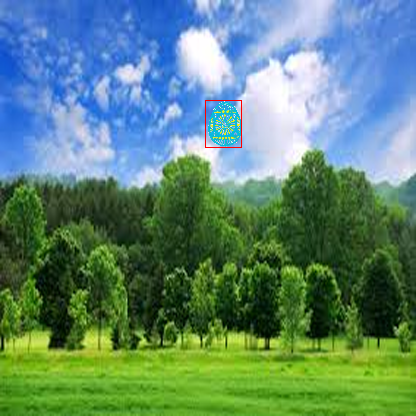

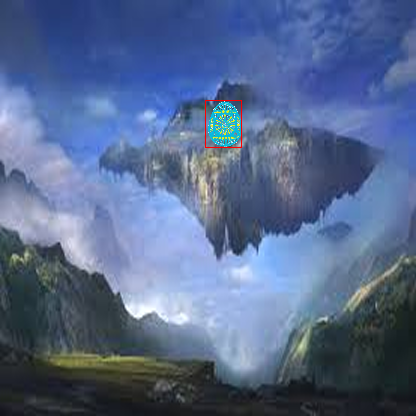

In [23]:
#print(img2_label)
auglist = create_augments_v2(fg1 = cv2.resize(img_orig, (50,50)), bg_list = backgrounds, labels = list(img2_label.keys()), i = 4, j = 2)
for img, labels in auglist:
  lbl = yolo_to_opencv(img, labels[1:])
  start_point = (lbl[0],lbl[1])
  end_point = (lbl[2], lbl[3])
  img2 = img.copy()
  cv2_imshow(cv2.rectangle(img2, start_point, end_point, color = (0,0,255), thickness = 1))
  #pass

In [ ]:
# No need to run this cell

flake = cv2.imread('/content/gdrive/MyDrive/Image Classification/pToArjn9c.png')
flake = cv2.resize(flake, (40,40))
cv2_imshow(flake)

In [ ]:
# No need to run this cell

auglist = create_augments_v2(flake, backgrounds, labels = None, i = 3, j = 3)

In [24]:
# Warning: This will overwrite any existing files with the same name. 
#Change the names before re-running otherwise existing progress would be lost.

for i in range(len(auglist)):
  img_name = f"/content/gdrive/MyDrive/Image Classification/Created_Samples/augmented_image_{i}.jpg"
  label_name = f"/content/gdrive/MyDrive/Image Classification/Created_Samples/augmented_image_{i}.txt"
  image, label = auglist[i]
  label_df = pd.DataFrame([label])
  label_df.to_csv(label_name, header=None, index=None, sep=' ', mode='w')
  cv2.imwrite(img_name, image)